In [1]:
using JuMP, Gurobi, IPG

In [2]:
n = m = 2

X1 = Model()
@variable(X1, x1[1] >= 0)

X2 = Model()
@variable(X2, x2[1] >= 0)

players = [
    Player(X1, QuadraticPayoff(0, [2, 1]), 1),
    Player(X2, QuadraticPayoff(0, [1, 2]), 2)
]

┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/vscode/.julia/packages/JuMP/CU7H5/src/Containers/DenseAxisArray.jl:185
┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/vscode/.julia/packages/JuMP/CU7H5/src/Containers/DenseAxisArray.jl:185


2-element Vector{Player}:
 Player(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 1
├ num_constraints: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 1
└ Names registered in the model
  └ :x1, QuadraticPayoff([0.0], [[2.0;;], [1.0;;]]), 1)
 Player(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 1
├ num_constraints: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 1
└ Names registered in the model
  └ :x2, QuadraticPayoff([0.0], [[1.0;;], [2.0;;]]), 2)

In [3]:
x = [[0],[0]]
payoff(players[1], x), payoff(players[2], x)

(0.0, 0.0)

# Step 1: Initialization

Compute one pure strategy for each player. Build sampled normal-form game.

In [4]:
function find_feasible_pure_strategy(player::Player; Optimizer=Gurobi.Optimizer)
    model = player.Xp

    set_optimizer(model, Optimizer)

    # it is simply a feasibility problem
    @objective(model, Min, 0)

    set_silent(model)
    optimize!(model)

    return value.(all_variables(model))
end

function find_feasible_pure_profile(players::Vector{Player}; Optimizer=Gurobi.Optimizer)
    return [find_feasible_pure_strategy(player, Optimizer=Optimizer) for player in players]
end

x = find_feasible_pure_profile(players)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca


2-element Vector{Vector{Float64}}:
 [0.0]
 [0.0]

In [5]:
x[1][1] = 10
x[2][1] = 10
x

2-element Vector{Vector{Float64}}:
 [10.0]
 [10.0]

In [6]:
# sample of strategies
S_X = [Vector{Vector{Float64}}() for p in 1:m]
# S_X[p,j,i] is the i-th dimension of the j-th strategy of player p

for p in 1:m
    # add to sample the new strategy
    push!(S_X[p], x[p])
end

In [7]:
# for p in 1:m
#     # add to sample the new strategy
#     push!(S_X[p], [1.0])
# end

# Step 2: Solve sampled game

Compute a solution to the normal-form game with the sampled strategies.

In [8]:
# TODO: making the polymatrix with "self-produced utilities" breaks the algorithms in 
# NormalGames. I don't know why this is, but it is mentioned that they assume so in a
# comment of function `GenerateGame`.

# function get_polymatrix(S_X::Vector{<:Vector{<:Vector{<:Real}}}, Π::Vector{QuadraticPayoff})
#     m = length(S_X)

#     dims = [length(S_X[p]) for p in 1:m]

#     polymatrix = Dict{Tuple{Integer, Integer}, Matrix{Float64}}()

#     # compute utility of each player `p` using strategy `i_p` against player `k` using strategy `i_k`
#     for p in 1:m
#         for k in 1:m
#             polymatrix[p,k] = zeros(length(S_X[p]), length(S_X[k]))

#             if k == p  # fills only the diagonal
#                 # TODO: this could be optimized by storing just the diagonal as well
#                 for i_p in 1:length(S_X[p])
#                     polymatrix[p,p][i_p,i_p] = IPG.bilateral_payoff(Π[p], p, S_X[p][i_p], p, S_X[p][i_p])
#                 end
#             else
#                 for i_p in 1:length(S_X[p])
#                     for i_k in 1:length(S_X[k])
#                         polymatrix[p,k][i_p,i_k] = IPG.bilateral_payoff(Π[p], p, S_X[p][i_p], k, S_X[k][i_k])
#                     end
#                 end
#             end
#         end
#     end

#     return polymatrix
# end

# polymatrix = get_polymatrix(S_X, Π)

In [40]:
function get_polymatrix(S_X::Vector{<:Vector{<:Vector{<:Real}}}, players::Vector{Player})
    dims = [length(S_X[player.p]) for player in players]

    polymatrix = Dict{Tuple{Integer, Integer}, Matrix{Float64}}()

    # compute utility of each player `p` using strategy `i_p` against player `k` using strategy `i_k`
    for p in 1:m
        for k in 1:m
            polymatrix[p,k] = zeros(length(S_X[p]), length(S_X[k]))

            if k != p  # fills only the diagonal
                for i_p in 1:length(S_X[p])
                    for i_k in 1:length(S_X[k])
                        polymatrix[p,k][i_p,i_k] = (
                            IPG.bilateral_payoff(players[p], S_X[p][i_p], players[k], S_X[k][i_k])
                            + IPG.bilateral_payoff(players[p], S_X[p][i_p], players[p], S_X[p][i_p])
                        )
                    end
                end
            end
        end
    end

    return polymatrix
end

polymatrix = get_polymatrix(S_X, players)

Dict{Tuple{Integer, Integer}, Matrix{Float64}} with 4 entries:
  (1, 2) => [0.0 -75.0 -93.75; 25.0 -12.5 -21.875; 10.9375 1.5625 -0.78125]
  (1, 1) => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  (2, 2) => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  (2, 1) => [0.0 -50.0 -87.5; 18.75 6.25 -3.125; 5.85938 2.73438 0.390625]

In [41]:
using NormalGames

G = NormalGames.NormalGame(m, length.(S_X), polymatrix)

NormalGames.NormalGame(2, [3, 3], Dict((1, 2) => [0.0 -75.0 -93.75; 25.0 -12.5 -21.875; 10.9375 1.5625 -0.78125], (1, 1) => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], (2, 2) => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], (2, 1) => [0.0 -50.0 -87.5; 18.75 6.25 -3.125; 5.859375 2.734375 0.390625]))

In [42]:
t, NE_utilities, NE_mixed = NormalGames.NashEquilibriaPNS(G,false,false,false)
# each element in NE_mixed is a mixed NE, represented as a vector of probabilities in the same shape as S_X

NE_mixed = NE_mixed[1]  # take the first NE

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Acad

2-element Vector{Vector{Float64}}:
 [0.0, 0.0, 1.0]
 [0.0, 0.0, 1.0]

In [43]:
σ = [IPG.DiscreteMixedStrategy(NE_mixed[p], S_X[p]) for p in 1:m]

2-element Vector{DiscreteMixedStrategy}:
 DiscreteMixedStrategy([1.0], [[1.25]])
 DiscreteMixedStrategy([1.0], [[0.625]])

# Step 3: Termination

Build a new strategy from the best reactions of each player.
Check if the new strategy is $\varepsilon$-close to the mixed NE.

In [44]:
function deviation_reaction(player::Player, σ::Vector{DiscreteMixedStrategy}; Optimizer=Gurobi.Optimizer)
    model = player.Xp
    set_optimizer(model, Optimizer)

    xp = all_variables(model)

    # TODO: No idea why the following doesn't work
    # @objective(model, Max, sum([IPG.bilateral_payoff(Πp, p, xp, k, σ[k]) for k in 1:m]))

    obj = QuadExpr()
    for k in 1:m
        obj += IPG.bilateral_payoff(player.Πp, player.p, xp, k, σ[k])
    end
    @objective(model, Max, obj)

    set_silent(model)
    optimize!(model)

    return value.(xp)
end

deviation_reaction(players[1], σ)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca


1-element Vector{Float64}:
 0.3125

In [45]:
function termination(players::Vector{Player}, σ::Vector{DiscreteMixedStrategy})
    for p in 1:m
        player = players[p]
        new_x_p = deviation_reaction(player, σ)

        new_σ = copy(σ)
        new_σ[p] = IPG.DiscreteMixedStrategy([1], [new_x_p])
        if payoff(player, σ) < payoff(player, new_σ)
            return p, new_x_p
        end
    end

    return -1, nothing
end

p, xk = termination(players, σ)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca


(1, [0.3125])

# Step 4: Generation of next sampled game

Add the newly found strategy for player $p$ to `S_X` (sampled game), and close the loop.

In [46]:
push!(S_X[p], xk)

4-element Vector{Vector{Float64}}:
 [10.0]
 [5.0]
 [1.25]
 [0.3125]

# Plots

In [47]:
using Plots

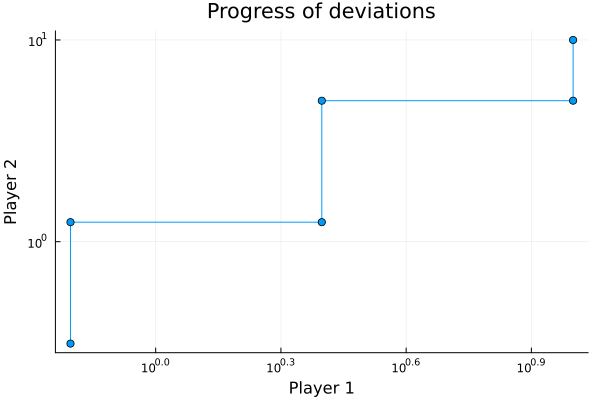

In [48]:
k = 1
points = []
while true
    i::Integer = floor(k / 2) + 1
    j::Integer = floor((k-1) / 2) + 1

    if i > length(S_X[1]) || j > length(S_X[2])
        break
    else
        push!(points, [S_X[1][i][1], S_X[2][j][1]])
        k += 1
    end
end

plot([p[2] for p in points], [p[1] for p in points], marker=:c, title="Progress of deviations", legend=false)
plot!(xscale=:log10, yscale=:log10)
xlabel!("Player 1")
ylabel!("Player 2")
# xlims!(0,10.2)
# ylims!(0,10.2)